# PIT - Práctica 3: Detección de Actividad de Voz (VAD)

**Alicia Lozano Díez**

11 de marzo de 2024


Nombres: Javier Alarcón y Enrique Ernesto de Alvear

Grupo 2

## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento de señales temporales de voz, y desarrollar de un detector de actividad de voz basado en redes neuronales recurrentes, en particular, LSTM.

### Materiales

- Guión (.ipynb) de la práctica - Moodle
- Ejemplos de datos y etiquetas - Moodle
- Listas de entrenamiento y validación - Moodle
- Scripts de descarga de datos - Moodle
- Datos y etiquetas de entrenamiento * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EdCueYU7BpNAuo6BawH8hJAB5rclap745BmsPzXgSPhsgw?e=VmkzaU)
- Datos y etiquetas de validación * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EWBjWyX774pLhJc2ahr4zk0BtLvWt7YGhdMDDmGu-LcBNQ?e=n2cHs5)


**CUIDADO: * Los datos proporcionados son de uso exclusivo para esta práctica. No tiene permiso para copiar, distribuir o utilizar el corpus para ningún otro propósito.**


# 1. Introducción al procesamiento de señales temporales de voz

## 1.1. Descarga de ficheros de ejemplo

Primero vamos a descargar el audio de ejemplo de Moodle (**audio_sample.wav**) y ejecutar las siguientes  líneas de código, que nos permitirán subir el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving audio_sample.wav to audio_sample (1).wav
Saving audio_sample_labels_1.voz to audio_sample_labels_1 (1).voz
Saving audio_sample_labels_2.voz to audio_sample_labels_2 (1).voz
Saving audio_sample_test.mat to audio_sample_test (1).mat
Saving audio_sample_test.wav to audio_sample_test (1).wav
Saving data_download_onedrive_training_VAD.sh to data_download_onedrive_training_VAD (1).sh
Saving data_download_onedrive_valid_VAD.sh to data_download_onedrive_valid_VAD (1).sh
Saving training_VAD.lst to training_VAD (1).lst
Saving valid_VAD.lst to valid_VAD (1).lst


Una vez cargado el fichero de audio, podemos escucharlo de la siguiente manera:

In [ ]:
import IPython

wav_file_name = "audio_sample.wav"
print(wav_file_name)
IPython.display.Audio(wav_file_name)

audio_sample.wav


## 1.2. Lectura y representación de audio en Python

A continuación vamos a definir ciertas funciones para poder hacer manejo de  ficheros de audio en Python.

Comenzamos definiendo una función **read_recording** que leerá un fichero de audio WAV, normalizará la amplitud y devolverá el vector de muestras _signal_ y su frecuencia de muestreo _fs_.

In [ ]:
import scipy.io.wavfile

def read_recording(wav_file_name):
  fs, signal = scipy.io.wavfile.read(wav_file_name)
  signal = signal/max(abs(signal)) # normalizes amplitude

  return fs, signal


Si ejecutamos la función anterior para el fichero de ejemplo, podemos ver la forma en la que se carga dicho fichero de audio en Python. Así, podemos obtener la frecuencia de muestreo y la longitud del fichero en número de muestras:

In [ ]:
fs, signal = read_recording(wav_file_name)
print("Signal variable shape: " + str(signal.shape))
print("Sample rate: " + str(fs))
print("File length: " + str(len(signal)) + " samples")


Signal variable shape: (67072,)
Sample rate: 16000
File length: 67072 samples


**PREGUNTAS:**

- ¿Como obtendría la duración de la señal en segundos?

$\frac{1}{sample\_rate}\cdot num\_samples = \frac{67072}{16000}=4.192s$

También podemos representar la señal y ver su forma de onda. Para ello, definimos la función **plot_signal** como sigue:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signal, fs, ylabel="", title=""):
  dur = len(signal)/fs
  step = 1./fs
  t_axis = np.arange(0., dur, step)

  plt.plot(t_axis, signal)
  plt.xlim([0, dur])
  plt.ylabel(ylabel)
  plt.xlabel('Time (seconds)')
  plt.title(title)
  plt.grid(True)


Y utilizando la función anterior, obtenemos su representación (amplitud frente al tiempo):

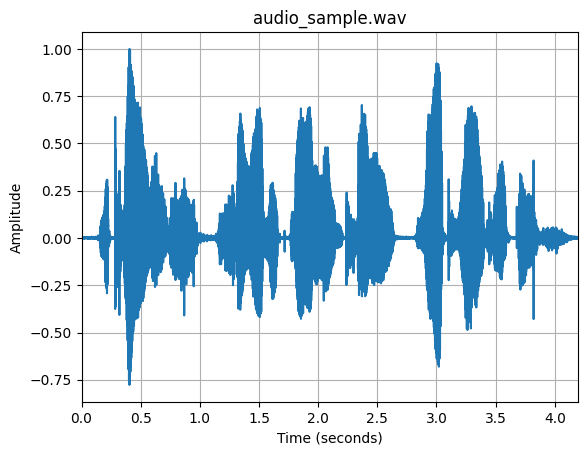

In [ ]:
plot_signal(signal, fs, "Amplitude", wav_file_name)
plt.show()

**PREGUNTAS:**
- Incluya en el informe la representación obtenida.

## 1.3. Representación de etiquetas de actividad de voz

En esta práctica, vamos a desarrollar un detector de actividad de voz, que determinará qué segmentos de la señal de voz son realmente voz y cuáles silencio.

Por ello, vamos a ver dos ejemplos de etiquetas _ground truth_, que corresponden al fichero de audio de ejemplo.

Primero, descargamos de Moodle las etiquetas de voz/silencio que están en los ficheros **audio_sample_labels_1.voz** y **audio_sample_labels_2.voz** y las cargamos en Google Colab como en el caso anterior.

In [ ]:
from google.colab import files
uploaded = files.upload()

Estas etiquetas están guardadas en ficheros de texto y podemos cargarlas en Python de la siguiente manera:

In [ ]:
labels_file_name = 'audio_sample_labels_1.voz'
voice_labels = np.loadtxt(labels_file_name)


Con el siguiente código, podemos representar la señal de voz así como sus etiquetas en la misma figura:

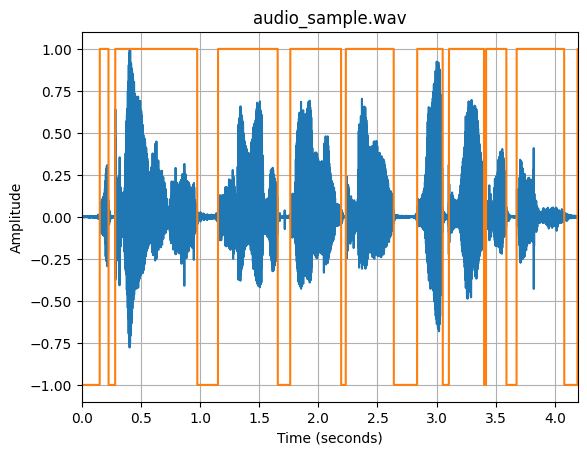

In [ ]:
plot_signal(signal, fs)
plot_signal(voice_labels*2-1, fs, "Amplitude", wav_file_name)
plt.show()

In [ ]:
labels_file_name2 = 'audio_sample_labels_2.voz'
voice_labels2 = np.loadtxt(labels_file_name2)

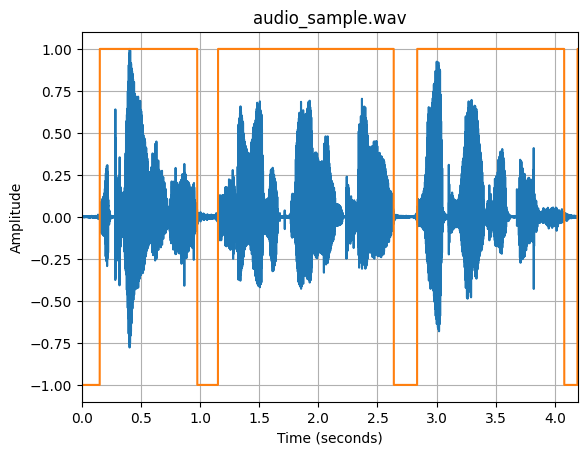

In [ ]:
plot_signal(signal, fs)
plot_signal(voice_labels2 * 2 -1, fs, "Amplitude", wav_file_name)
plt.show()

Las etiquetas de voz/silencio provienen de distintos detectores de actividad de voz.

**PREGUNTAS:**
- ¿Qué valores tienen las etiquetas? ¿Qué significan dichos valores?

Tienen valores $\in \lbrace 0, 1\rbrace$ donde 1 significa que hay voz y 0 que no.

- ¿Por qué se representa _voice_labels*2-1_?

Porque la señal de audio tiene amplitud de $\lbrace -1, 1\rbrace$ entonces para que tenga la misma escala

- Represente la señal de voz junto con las etiquetas para ambos casos e incluya las figuras en el informe de la práctica. ¿Qué diferencias observas? ¿A qué se puede deber?

En voice_labels1 se puede ver que hay trozos de silencio muy cortos, esto puede ser una confusión de una detección de silencio cuando puede que sea el tiempo entre palabras o fonemas, en el segundo conjunto de etiquetas sí que aparece más uniforme.

- ¿Qué cantidad de voz/silencio hay en cada etiquetado?

voice_labels1 = voz: 9 trozos y silencio: 10

voice_labels2 = vox: 3 trozos y silencio : 4

## 1.4. Extracción de características

En la mayoría de sistemas de reconocimiento de patrones, un primer paso es la extracción de características. Esto consiste, a grandes rasgos, en obtener una representación de los datos de entrada, que serán utilizados para un posterior modelado.

En nuestro caso, vamos pasar de la señal en crudo _"raw"_ dada por las muestras (_signal_), a una secuencia de vectores de características que extraigan información a corto plazo de la misma y la representen. Esta sería la entrada a nuestro sistema de detección de voz basado en redes neuronales.

Para ver algunos ejemplos, vamos a utilizar la librería _librosa_ (https://librosa.org/doc/latest/index.html).

Dentro de esta librería, tenemos funciones para extraer distintos tipos de características de la señal de voz, como por ejemplo el espectrograma en escala Mel (_melspectrogram_).

Estas características a corto plazo, se extraen en ventanas de unos pocos milisegundos con o sin solapamiento.

Un ejemplo sería el siguiente:


In [ ]:
import librosa

mel_spec = librosa.feature.melspectrogram(y=signal,sr=fs,n_mels=23,win_length=320,hop_length=160)

print(mel_spec.shape)
print(signal.shape)

(23, 420)
(67072,)


**PREGUNTAS:**
- ¿Qué se obtiene de la función anterior?

Se obtiene el espectograma de Mel, que es un espectograma que utiliza la escala de Mel.

- ¿Qué significan los valores de los parámetros _win_length_ y _hop_length_?

_win_length_ : el tamaño de la ventana de audio

_hop_length_:numero de muestras entre frames consecutivos


- ¿Qué dimensiones de _mel_spec_ obtienes? ¿Qué significan?

(23,420)

transforma la señal S en el espectrograma en la escala mel, donde 420 es el número de ventanas producido y el 23 es la dimensión del vector en cada una de esas ventanas.

De esta manera, podríamos obtener una parametrización de las señales para ser utilizadas como entrada a nuestra red neuronal.

Para los siguientes apartados, se proporcionan los vectores de características MFCC para una serie de audios que se utilizarán como conjunto de entrenamiento del modelo de VAD.

#2. Detector de actividad de voz (Voice Activity Detector, VAD)



## 2.1. Descarga de los datos de entrenamiento

Primero vamos a descargar la lista de identificadores de los datos de entrenamiento de la práctica.

Para ello, necesitaremos descargar de Moodle el fichero **training_VAD.lst**, y ejecutar las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving audio_sample.wav to audio_sample.wav
Saving audio_sample_labels_1.voz to audio_sample_labels_1.voz
Saving audio_sample_labels_2.voz to audio_sample_labels_2.voz
Saving audio_sample_test.mat to audio_sample_test.mat
Saving audio_sample_test.wav to audio_sample_test.wav
Saving data_download_onedrive_training_VAD.sh to data_download_onedrive_training_VAD.sh
Saving data_download_onedrive_valid_VAD.sh to data_download_onedrive_valid_VAD.sh
Saving training_VAD.lst to training_VAD.lst
Saving valid_VAD.lst to valid_VAD.lst


A continuación cargamos los identificadores contenidos en el fichero en una lista en Python:

In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()

Podemos ver algunos de ellos (los primeros 10 identificatores) de la siguiente forma:

In [ ]:
print(train_list[:10])

['features_labs_1.mat', 'features_labs_10.mat', 'features_labs_100.mat', 'features_labs_101.mat', 'features_labs_102.mat', 'features_labs_103.mat', 'features_labs_104.mat', 'features_labs_105.mat', 'features_labs_106.mat', 'features_labs_107.mat']


Ahora, descargaremos de Moodle el fichero **data_download_onedrive_training_VAD.sh**, y ejecutaremos las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Para descargar el conjunto de datos desde One drive, ejecutamos el script cargado anteriormente de la siguiente manera:

In [ ]:
!chmod 755 data_download_onedrive_training_VAD.sh
!./data_download_onedrive_training_VAD.sh

--2024-03-12 10:57:27--  https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EdCueYU7BpNAuo6BawH8hJAB5rclap745BmsPzXgSPhsgw?download=1
Resolving dauam-my.sharepoint.com (dauam-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to dauam-my.sharepoint.com (dauam-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/alicia_lozano_uam_es/Documents/PIT/training_VAD.zip?ga=1 [following]
--2024-03-12 10:57:27--  https://dauam-my.sharepoint.com/personal/alicia_lozano_uam_es/Documents/PIT/training_VAD.zip?ga=1
Reusing existing connection to dauam-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3638232935 (3.4G) [application/x-zip-compressed]
Saving to: ‘EdCueYU7BpNAuo6BawH8hJAB5rclap745BmsPzXgSPhsgw?download=1’

EdCueYU7BpNAuo6BawH 100%[===================>]   3.39G  54.0MB/s    in 66s     

2024-03-12 10:58:34 (52.7 MB/s) - ‘EdCueYU7BpNAuo6BawH8hJA

Este script descargará los datos de One Drive y los cargará en Google Colab, descomprimiéndolos en la carpeta **data/training_VAD**.

Podemos comprobar que los ficheros **.mat** se encuentran en el directorio esperado:


In [ ]:
!ls data/training_VAD/ | head

features_labs_100.mat
features_labs_101.mat
features_labs_102.mat
features_labs_103.mat
features_labs_104.mat
features_labs_105.mat
features_labs_106.mat
features_labs_107.mat
features_labs_108.mat
features_labs_109.mat


## 2.2. Definición del modelo

Utilizando la librería Pytorch (https://pytorch.org/docs/stable/index.html), vamos a definir un modelo de ejemplo con una capa LSTM y una capa de salida. La capa de salida estará formada por una única neurona. La salida indicará la probabilidad de voz/silencio utilizando una función *sigmoid*.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model_1(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1, self).__init__()

        self.lstm = nn.LSTM(feat_dim,256,batch_first=True,bidirectional=False)
        self.output = nn.Linear(256,1)

    def forward(self, x):

        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

**PREGUNTAS:**
- ¿Qué tamaño tiene la entrada a la capa LSTM?

20

- ¿Cuántas unidades (celdas) tiene dicha capa LSTM?

256

- ¿Qué tipo de matriz espera la LSTM? Mirar la documentación y describir brevemente.

Espera una matriz de tamaño (L,N,H_in) donde N es el batch size, L es el sequence length y H_in es el input size.

- Revisar la documentación de _torch.nn.LSTM_ y describir brevemente los argumentos _batch_first_, _bidirectional_ y _dropout_.

batch_first = Dice si el primer parámetro de la tupla de entrada y salida es el batch size o el sequence legth.

bidirectional = si la secuencia se mira de forma bidireccional, es decir en ambos sentidos.

dropout = si hay un factor de dropout, donde se hace 0 un cierto porcentaje de las salidas, para evitar sobreajuste.

- En este modelo, estamos utilizando una única neurona a la salida. ¿Hay alguna otra alternativa? ¿Se seguiría utilizando una función _sigmoid_?

Queremos hacer un clasificador de dos clases, entonces lo mejor es hacer una única salida, si quisiéramos hacer clasificación multiclase entonces podríamos tener varias neuronas de salida y utilizar la función softmax de salida por ejemplo.

- ¿Para qué sirve la función _forward_ definida en la clase _Model_1_?

Determina el avance de la red neuronal, primero la salida de la capa lstm, entra luego en la capa output y la salida de esta se pasa por la sigmoide para hacer la salida de la red.

Una vez definida la clase, podemos crear nuestra instancia del modelo y cargarlo en la GPU con el siguiente código:

In [ ]:
model = Model_1(feat_dim=20)
model = model.to(torch.device("cuda"))
print(model)

Model_1(
  (lstm): LSTM(20, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Nuestra variable _model_ contiene el modelo, y ya estamos listos para entrenarlo y evaluarlo.

##2.3. Lectura y preparación de los datos para el entrenamiento

Como hemos visto anteriormente, nuestros datos están guardados en ficheros de Matlab (**.mat**). Cada uno de estos ficheros contiene una matriz **X** correspondiente a las secuencias de características MFCC (con sus derivadas de primer y segundo orden), y un vector **Y** con las etiquetas de voz/silencio correspondientes.

Veamos un ejemplo:


In [ ]:
features_file = 'data/training_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file)['X']
labels = scipy.io.loadmat(features_file)['Y']

print(features.shape)
print(labels.shape)


(46654, 60)
(46654, 1)


**PREGUNTAS:**
Elegir un fichero de entrenamiento y responder a las siguientes preguntas:
- ¿Qué tamaño tiene **features**? ¿Y **labels**?

Features: tiene 46654 instancias con 60 carácterísticas cada una

labels: hay 46654 instancias con una sola carácterística cada una que determina la clase.

- Una de las dimensiones de la **features** es 60, correspondiente a los 20 coeficientes MFCC concatenados con las derivadas de primer y segundo orden. ¿Con qué se corresponde la otra dimensión?

Con el número de instancias

El entrenamiento del modelo se va a realizar mediante descenso por gradiente (o alguna de sus variantes) basado en _batches_.

Para preparar cada uno de estos _batches_ que servirán de entrada a nuestro modelo LSTM, debemos almacenar las características en secuencias de la misma longitud. El siguiente código lee las características (**get_fea**) y sus correspondientes etiquetas (**get_lab**) de un fragmento aleatorio del fichero de entrada.

In [ ]:
import scipy.io
import numpy as np

def get_fea(segment, rand_idx):
    data = scipy.io.loadmat(segment)['X']
    if data.shape[0] <= length_segments:
        start_frame = 0
    else:
        start_frame = np.random.permutation(data.shape[0]-length_segments)[0]

    end_frame = np.min((start_frame + length_segments,data.shape[0]))
    rand_idx[segment] = start_frame
    feat = data[start_frame:end_frame,:20] # discard D and DD, just 20 MFCCs
    return feat[np.newaxis, :, :]


def get_lab(segment, rand_idx):
    data = scipy.io.loadmat(segment)['Y']
    start_frame = rand_idx[segment]
    end_frame = np.min((start_frame + length_segments, data.shape[0]))
    labs = data[start_frame:end_frame].flatten()
    return labs[np.newaxis,:]

**PREGUNTAS:**
Analizar las funciones anteriores detenidamente y responder a las siguientes cuestiones:
- ¿De qué tamaño son los fragmentos que se están leyendo?

Tiene de longitud el tamaño de la variable length_segments que posteriormente se utilizará 300

- ¿Para qué sirve _rand_idx_?

El índice donde se empieza a mirar cada fragmento


## 2.4. Entrenamiento del modelo
Una vez definidas las funciones de lectura de datos y preparación del formato que necesitamos para la entrada a la red LSTM, podemos utilizar el siguiente código para entrenarlo.

In [ ]:
length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

max_iters = 8
for epoch in range(1, max_iters):
  print('Epoch: ',epoch)
  model.train()
  cache_loss = 0

  correct = 0
  count = 0
  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    count += len(train_batch)
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16)  for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label
    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))

    # Forward the data through the network
    outputs = model(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)
    labels_out = outputs.round()
    correct  += (labels_out == labs_batch).sum() / length_segments
    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

  acc = correct / count
  print("Loss: " + str(cache_loss/len(train_batch)))
  print(f"Acc: {acc}")


Epoch:  1
Loss: 0.12039661407470703
Acc: 0.6897450685501099
Epoch:  2
Loss: 0.09071573790381937
Acc: 0.7975948452949524
Epoch:  3
Loss: 0.06606186721839157
Acc: 0.85621577501297
Epoch:  4
Loss: 0.058053655659451205
Acc: 0.8845818042755127
Epoch:  5
Loss: 0.05461920096593745
Acc: 0.8868105411529541
Epoch:  6
Loss: 0.0592503968407126
Acc: 0.8807975649833679
Epoch:  7
Loss: 0.054670741160710655
Acc: 0.8863988518714905


**PREGUNTAS:**
Analizar el código anterior cuidadosamente y ejecutarlo. A continuación, responder a las siguientes cuestiones:
- ¿Qué función de coste se está optimizando? Describir brevemente con ayuda de la documentación.

binary crossentropy, intenta minimizar

$mean(L)$ o $sum(L)$ dependiendo del parámetro de entrada inicializado por defeco a hacer la media.

Donde $L = \lbrace l_1,...,l_n\rbrace$

$l_n = - w_n [ y_n \cdot \log (x_n) + (1-y_n)\log (1-x_n)]$



- ¿Qué optimizador se ha definido?

Adam con learning rate = $0.001$


- ¿Para qué se utiliza _batch_size_?

Para segmentar los datos de entrada en trozos de tamaño batch_size

- Describir brevemente la creación de los _batches_.

En primer lugar se segmentan los datos en trozos de longitud batch_size. Poteriormente coges cada trozo de los datos de entrada con la función get_fea, y las etiquetas correspondientes a esos datos para pasarselos a la red

- ¿Qué línea de código realiza el _forward pass_?

outputs = model(train_batch)

En esta linea se le pasa el batch de entrenamiento correspondiente

- ¿Qué línea de código realiza el _backward pass_?

loss.backward()

- ¿Cuántas iteraciones del algoritmo ha realizado? ¿Qué observa en la evolución de la función de coste?

4 y se va reduciendo el valor de la función de coste

- Añada al código el cálculo de la precisión o _accuracy_, de tal manera que se muestre por pantalla dicho valor en cada iteración (similar a lo que ocurre con el valor del coste _loss_). Copiar el código en el informe y describir brevemente.

labels_out = outputs.round()

$count =  \sum len(train\_batch)$

$correct = \sum(labels\_out == labs\_batch) /length\_segments$

$Acc = \frac{correct}{count}$

Es decir, vemos que etiquetas predice correctamente por segmento y lo dividimos entre la longitud del segmento, finalmente calculamos la media de todos los segmentos.

- ¿Qué valor de coste y _accuracy_ obtiene? ¿Cómo se puede mejorar?

Loss: 0.054670741160710655

Acc: 0.8863988518714905

Con más etapas o aumentando la complejidad de la red.

## 2.5. Evaluación del modelo: un único fichero de test

Una vez entrenado el modelo, vamos a evaluarlo en un ejemplo en concreto.

Descargue de Moodle el fichero **audio_sample_test.wav**, con sus correspondientes características y etiquetas **audio_sample_test.mat** y evalúe el rendimiento en el mismo.


(57777, 20)
(46654, 1)


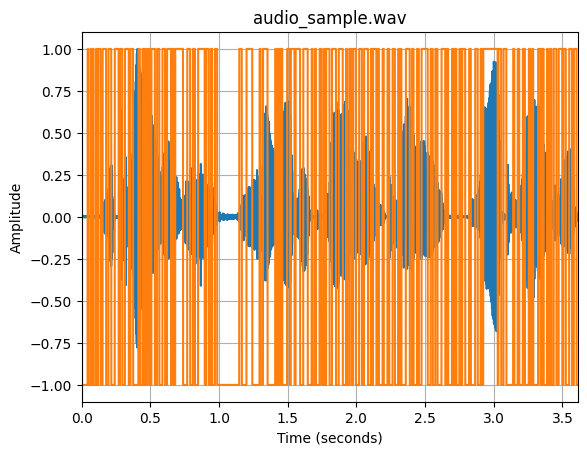

In [ ]:
uploaded = files.upload()
features_file = 'audio_sample_test.mat'
# Obtain features and labels
features = scipy.io.loadmat(features_file)['X'][:,:20]
etiquetas = scipy.io.loadmat(features_file)['Y'].flatten().astype("float32")


print(features.shape)
print(labels.shape)

plot_signal(signal, fs)
plot_signal(etiquetas*2-1, fs, "Amplitude", wav_file_name)
plt.show()

In [ ]:
model.eval()
feat_audio = torch.tensor(features[np.newaxis, :,:].astype("float32")).to(torch.device("cuda"))

outputs = model(feat_audio)

labels_out = outputs.round().cpu().detach().numpy().flatten()

print("ACC: ", np.sum((labels_out == etiquetas)) / (len(etiquetas)))

ACC:  0.9116430413486335



**PREGUNTAS:**
- Incluya en el informe de la práctica el código que ha utilizado para evaluar dicho fichero.
- ¿Cuál es el _accuracy_ obtenido para el fichero **audio_sample_test**?

  ACC:  0.9099295567440331
- Represente 10 segundos de dicho audio, así como sus etiquetas de _ground_truth_ y las obtenidas con su modelo. Incluya dicha gráfica en el informe y comente brevemente el resultado. Visualmente, ¿es bueno el modelo?
- Escuche el audio y comente cualitativamente cómo es de bueno o malo el modelo.


## 2.6. Evaluación del modelo: conjunto de validación





Ahora vamos a evaluar el rendimiento del modelo anterior sobre un conjunto de validación (del que conocemos sus etiquetas).

Para este conjunto de datos, descargaremos la lista de identificadores **valid_VAD.lst** de Moodle, así como el fichero de descarga de datos **data_download_onedrive_valid_VAD.sh**:

In [ ]:
!ls -al

total 18068
drwxr-xr-x 1 root root    4096 Mar 11 21:08 .
drwxr-xr-x 1 root root    4096 Mar 11 20:51 ..
-rw-r--r-- 1 root root  134144 Mar 11 21:04 audio_sample_labels_1.voz
-rw-r--r-- 1 root root  134144 Mar 11 21:04 audio_sample_labels_2.voz
-rw-r--r-- 1 root root 8442062 Mar 11 21:04 audio_sample_test.mat
-rw-r--r-- 1 root root 9600364 Mar 11 21:04 audio_sample_test.wav
-rw-r--r-- 1 root root  134188 Mar 11 21:04 audio_sample.wav
drwxr-xr-x 4 root root    4096 Mar  8 14:25 .config
drwxr-xr-x 3 root root    4096 Mar 11 21:08 data
-rwxr-xr-x 1 root root     456 Mar 11 21:04 data_download_onedrive_training_VAD.sh
-rw-r--r-- 1 root root     444 Mar 11 21:04 data_download_onedrive_valid_VAD.sh
drwxr-xr-x 3 root root    4096 Mar 11 21:08 __MACOSX
drwxr-xr-x 1 root root    4096 Mar  8 14:25 sample_data
-rw-r--r-- 1 root root   11112 Mar 11 21:04 training_VAD.lst
-rw-r--r-- 1 root root    1503 Mar 11 21:04 valid_VAD.lst


In [ ]:
from google.colab import files
uploaded = files.upload()

!chmod 755 data_download_onedrive_valid_VAD.sh
!./data_download_onedrive_valid_VAD.sh



mkdir: cannot create directory ‘./data’: File exists
--2024-03-12 11:15:05--  https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EWBjWyX774pLhJc2ahr4zk0BtLvWt7YGhdMDDmGu-LcBNQ?download=1
Resolving dauam-my.sharepoint.com (dauam-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to dauam-my.sharepoint.com (dauam-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/alicia_lozano_uam_es/Documents/PIT/valid_VAD.zip?ga=1 [following]
--2024-03-12 11:15:05--  https://dauam-my.sharepoint.com/personal/alicia_lozano_uam_es/Documents/PIT/valid_VAD.zip?ga=1
Reusing existing connection to dauam-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 508492067 (485M) [application/x-zip-compressed]
Saving to: ‘EWBjWyX774pLhJc2ahr4zk0BtLvWt7YGhdMDDmGu-LcBNQ?download=1’

EWBjWyX774pLhJc2ahr 100%[===================>] 484.94M  45.6MB/s    in 13s     

2024-03-12 1

Escriba ahora el código necesario para evaluar el modelo anterior en el conjunto de datos de validación, para su última época.

Tenga en cuenta que si quiere realizar el forward para todos los datos de validación de una vez, necesitará que todas las secuencias sean de la misma longitud. Como aproximación, puede escoger unos pocos segundos de cada fichero como se hace en el entrenamiento.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

file_train_list = 'valid_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()

length_segments = 300
path_in_feat = 'data/valid_VAD/'

from torch import optim
def validacion(model, train_list, path_in_feat):
  model.eval()
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  batch_size = 51
  segment_sets = np.array_split(train_list, len(train_list)/batch_size)

  max_iters = 5
  model.eval()
  cache_loss = 0

  for ii, segment_set in enumerate(segment_sets):
      rand_idx = {}
      optimizer.zero_grad()

      # Create training batches
      train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
      labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16)  for segment in segment_set])
      assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label
      # Shuffle the data and place them into Pytorch tensors
      shuffle = np.random.permutation(len(labs_batch))
      labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))
      train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))

      # Forward the data through the network
      outputs = model(train_batch)

      # Compute cost
      loss = criterion(outputs, labs_batch)
      labels_out = outputs.round()
      acc = torch.sum((labels_out == labs_batch)) / (labs_batch.shape[0] * labs_batch.shape[1] )
      # Backward step
      #loss.backward()#Quitamos paso backward porque estamos evaluando
      optimizer.step()
      cache_loss += loss.item()

  print("Loss: " + str(cache_loss/len(train_batch)))
  print(f"Acc: {acc}")
  return cache_loss/len(train_batch), acc


In [ ]:
  loss, acc = validacion(model , train_list, path_in_feat)

Loss: 0.003567092948489719
Acc: 0.901805579662323


**PREGUNTAS:**
- Incluya en la memoria de la práctica el código utilizado, incluyendo los valores de cualquier parámetro de configuración utilizado (por ejemplo, el número de épocas de entrenamiento realizadas).

Para ello se ha puesto el modelo en modo evaluación y se ha hecho una iteración con el algoritmo de entrenamiento, sin hacer el backward ya que no queremos reentrenar el modelo, si no que solo queremos evaluar, el n_batches es 71, de tamaño 300

- ¿Qué rendimiento (loss y accuracy) obtiene con este modelo (_Model_1_) en entrenamiento y en validación?

En entrenamiento:

  Loss: 0.054670741160710655
  
  Acc: 0.8863988518714905

En validación:

  Loss: 0.003567092948489719
  
  Acc: 0.901805579662323  

# 3. Comparación de modelos



## 3.1. Redes LSTM bidireccionales

En este apartado, vamos a partir del modelo inicial (_Model_1_) y modificarlo para que la capa LSTM sea bidireccional (_Model_1B_).

Entrene el nuevo modelo y compare el resultado con el modelo inicial.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

class Model_1B(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1B, self).__init__()

        self.lstm_bid = nn.LSTM(feat_dim, 256, batch_first=True, bidirectional=True)
        self.output = nn.Linear(512,1)

    def forward(self, x):

        out = self.lstm_bid(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

In [ ]:
model_bir = Model_1B(feat_dim=20)
model_bir = model_bir.to(torch.device("cuda"))
print(model_bir)

Model_1B(
  (lstm_bid): LSTM(20, 256, batch_first=True, bidirectional=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()

length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model_bir.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

max_iters = 5

for epoch in range(1, max_iters):
  print('Epoch: ',epoch)
  model_bir.train()
  cache_loss = 0

  correct = 0
  count = 0
  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    count += len(train_batch)
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16)  for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label
    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))

    # Forward the data through the network
    outputs = model_bir(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)
    labels_out = outputs.round()
    correct  += (labels_out == labs_batch).sum() / length_segments
    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

  acc = correct / count
  print("Loss: " + str(cache_loss/len(train_batch)))
  print(f"Acc: {acc}")

Epoch:  1
Loss: 0.11648033237924763
Acc: 0.7015883326530457
Epoch:  2
Loss: 0.08187519101535573
Acc: 0.8215687274932861
Epoch:  3
Loss: 0.054917071964226516
Acc: 0.8862811326980591
Epoch:  4
Loss: 0.049872546511537885
Acc: 0.9006274938583374


In [ ]:
file_validation_list = 'valid_VAD.lst' # mat files containing data + labels
f = open(file_validation_list, 'r')
validation_list = f.read().splitlines()
f.close()

length_segments = 300
path_in_feat_validation = 'data/valid_VAD/'
loss, acc = validacion(model_bir , validation_list, path_in_feat_validation)

Loss: 0.003260469064116478
Acc: 0.9083333611488342


**PREGUNTAS:**
- Explique brevemente la diferencia entre una capa LSTM y una BLSTM (bidirectional LSTM).
    
    Una BLSTM está formada por dos capas LSTM, pero una de ellas se recorre en sentido contrario. Por tanto, este tipo de capas permiten obtener un contexto global de la señal, ya que tienen en cuenta el contexto del futuro. Sin embargo, no sirven para analizar señales en tiempo real, ya que necesitamos conocer la señal en su totalidad.


- Incluya el código donde define _Model_1B_ en el informe de la práctica.


- ¿Qué modelo obtiene un mejor resultado sobre los datos de validación? ¿Por qué puede ocurrir esto?

    BLSTM:

    Loss: 0.003260469064116478

    Acc: 0.9083333611488342

    LSTM:

    Loss: 0.003567092948489719
  
    Acc: 0.901805579662323

Podemos ver que ambos modelos consiguen resultados similares. Sin embargo, el modelos BLSTM se ha entrenado solo durante 4 epoch mientas que el modelo LSTM se ha entrenado durante 7. Esto demuestra que los modelos BLSTM consiguen resultados similares con menos entrenamiento gracias a tomar el contexto del futuro. Si entrenasemos el modelo BLSTM durante los mismos epoch seguramente obtengamos mejores resultados.

## 3.2. Modelo "más profundo"

En este apartado, vamos a partir nuevamente del modelo _Model_1_ y vamos a añadir una segunda capa LSTM tras la primera, con el mismo tamaño y configuración, definiendo un nuevo modelo _Model_2_.

Entrénelo y compare los resultados.

In [ ]:

class Model_2(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_2, self).__init__()

        self.lstm1 = nn.LSTM(feat_dim,256,batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(feat_dim,128, batch_first=True, bidirectional=False)
        self.output = nn.Linear(128,1)

    def forward(self, x):

        out = self.lstm1(x)[0]
        out = self.lstm2(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

In [ ]:
model_2 = Model_2(feat_dim=20)
model_2 = model_2.to(torch.device("cuda"))
print(model_2)

Model_2(
  (lstm1): LSTM(20, 256, batch_first=True)
  (lstm2): LSTM(20, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()


length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

max_iters = 5

for epoch in range(1, max_iters):
  print('Epoch: ',epoch)
  model_2.train()
  cache_loss = 0

  correct = 0
  count = 0
  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    count += len(train_batch)
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16)  for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label
    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))

    # Forward the data through the network
    outputs = model_2(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)
    labels_out = outputs.round()
    correct  += (labels_out == labs_batch).sum() / length_segments
    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

  acc = correct / count
  print("Loss: " + str(cache_loss/len(train_batch)))
  print(f"Acc: {acc}")

Epoch:  1
Loss: 0.12936327737920425
Acc: 0.6065360307693481
Epoch:  2
Loss: 0.11142945172739964
Acc: 0.7559936046600342
Epoch:  3
Loss: 0.0959960122903188
Acc: 0.7894967794418335
Epoch:  4
Loss: 0.07457336549665414
Acc: 0.8360980749130249


In [ ]:
loss, acc = validacion(model_2 , validation_list, path_in_feat_validation)

Loss: 0.004470591743787129
Acc: 0.8637962937355042


**PREGUNTAS:**
- Incluya el código de la clase _Model_2_ en la memoria.
- ¿Qué modelo obtiene un mejor resultado sobre los datos de validación, _Model_1_ o _Model_2_? ¿Por qué puede ocurrir esto?

    Model_1

    Loss: 0.003260469064116478

    Acc: 0.9083333611488342

    Model_2

    Loss: 0.004470591743787129

    Acc: 0.8637962937355042

    Ambos modelos obtienen resultados parecidos, aunque los resultados de Model_2 son ligeramente inferiores, esto puede deberse a la aleatorización de los pesos iniciales, si entrenasemos ambos modelos durante más epoch seguramente obtengamos mejores resultados con este último modelo.


- Y con respecto a _Model_1B_, ¿cuál es mejor?

    Model_1B

    Loss: 0.003567092948489719
  
    Acc: 0.901805579662323

    Las conclusiones son análogas a las mencionadas en el apartado anterior, es cierto que Model_1B tiene mejores resultados, pero esto seguramente se debe a que lo hemos entrenado más tiempo.
